Music generation

In [3]:
from music21 import *
import random

def make_music(key_input):

  key_str = key_input
  key_obj = key.Key(key_str)
  time_signature = meter.TimeSignature('4/4')

  # Define a melody with a random sequence of notes
  melody = stream.Stream()
  melody.append(key_obj)
  melody.append(time_signature)

  for i in range(8):
      note_name = random.choice(scale.MajorScale(key_str).getPitches() + scale.MelodicMinorScale(key_str).getPitches())
      note_obj = note.Note(note_name)
      note_obj.duration = duration.Duration(random.choice([0.25, 0.5, 1, 2]))
      melody.append(note_obj)

  # Write the melody to a MIDI file
  midi_filename = 'output.mid'
  melody.write('midi', fp=midi_filename)

def get_key(type):
  if type == "major":
    key = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
  else:
    key = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
  return random.choice(key)


make_music(get_key('major'))

ML Model

In [4]:
import pandas as pd
import io

train = pd.read_csv('emotion-labels-train.csv')
test = pd.read_csv('emotion-labels-test.csv')

In [5]:
print(len(train))
train.head()

3613


,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [6]:
print(len(test))
test.head()

3142


,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [7]:
pd.unique(train.label)

array(['joy', 'fear', 'anger', 'sadness'], dtype=object)

Text(0, 0.5, 'Count')

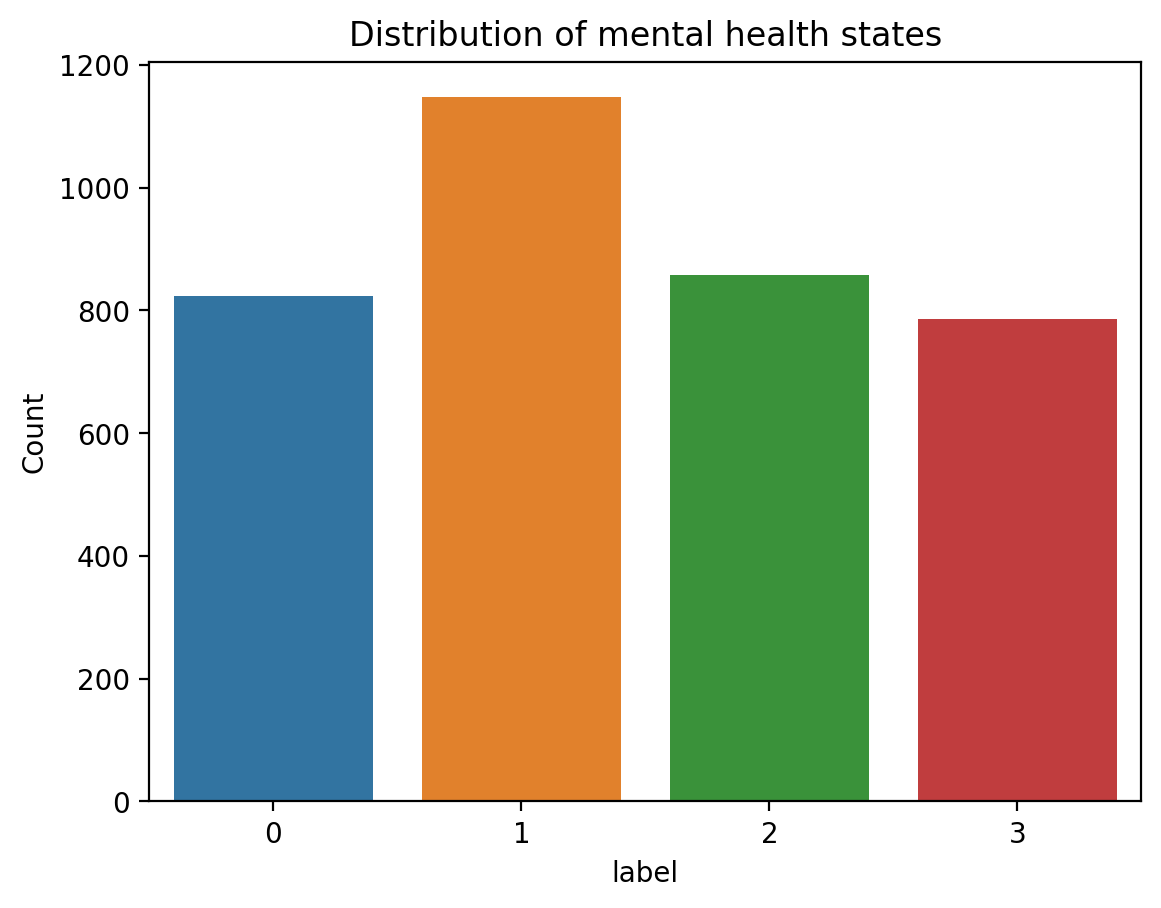

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the emotion mapping dictionary
emotion_map = {
    'joy' : 0,
    'fear' : 1,
    'anger' : 2,
    'sadness' : 3,
}

# Map numerical labels to emotional categories
train['label'] = train['label'].map(lambda x: emotion_map[x])
train['label'] = pd.Categorical(train['label'], categories=emotion_map.values())

sns.countplot(x='label', data=train)
plt.title('Distribution of mental health states')
plt.ylabel('Count')


In [9]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 7.8 MB/s eta 0:00:00


In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze(set):

  analyzer = SentimentIntensityAnalyzer()

  sentiment_scores = []
  for message in set['text']:
      score = analyzer.polarity_scores(str(message))
      sentiment_scores.append(score['compound'])

  set['mh_state'] = sentiment_scores

In [11]:
analyze(train)
analyze(test)

In [12]:
train.head()

,text,label,mh_state
0,Just got back from seeing @GaryDelaney in Burs...,0,0.8479
1,Oh dear an evening of absolute hilarity I don'...,0,0.8313
2,Been waiting all week for this game ❤️❤️❤️ #ch...,0,0.5106
3,"@gardiner_love : Thank you so much, Gloria! Yo...",0,0.9839
4,I feel so blessed to work with the family that...,0,0.7306


In [13]:
# create boundaries
import numpy as np

def get_ma_mi(set):

  score_avg = np.mean(set['mh_state'])

  if score_avg > -0.3:
    return 'major'
  else:
    return 'minor'


get_ma_mi(train)

'major'

In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 25.4 MB/s eta 0:00:00


In [15]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_list = stopwords.words('english')

stopwords_with_apostrophes = list(stopwords_list)
new_stopwords = ["i'm", "imma", "ain't"]

stopwords_with_apostrophes.extend(new_stopwords)

for word in stopwords_list:
    if "'" in word:
        new_word = word.replace("'", "")
        stopwords_with_apostrophes.append(new_word)

stopwords_list = stopwords_with_apostrophes

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
from nltk.stem import WordNetLemmatizer
import re
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

def clean(text):
        text = text.lower() # convert to lowercase
        text = re.sub(r'[^\w\s#]','' , text) # drop all non word and whitespace characters, except for the hashtag
        text = re.sub(r'\d+', 'NUM', text) # replace all digits with NUM
        text = ' '.join([word for word in text.split() if word not in stopwords.words("english")]) # remove stopwords
        return text

train['proc_text'] = train['text'].apply(clean)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
encoded_texts = tokenizer(train['proc_text'].values.tolist(), padding=True, truncation=True, return_tensors='tf')
word_index = tokenizer.get_vocab()

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train['proc_text'].values)

targets = train['label'].values

In [17]:
tokenizer.save_pretrained('/content/')

('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.txt',
 '/content/added_tokens.json',
 '/content/tokenizer.json')

In [19]:
import pickle

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train['proc_text'].values)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectors, targets, test_size=0.2, random_state=42)

In [21]:
!pip show xgboost

Name: xgboost
Version: 1.7.5
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: numpy, scipy
Required-by: 


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': np.arange(0.2, 0.5, 0.05),
    'n_estimators': np.arange(100, 400, 50)
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=5, cv=2)
random_search.fit(x_train, y_train)

print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_:.3f}')

Best parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2}
Best score: 0.798


In [23]:
model = XGBClassifier(**random_search.best_params_)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [24]:
import pickle
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(random_search.best_estimator_, file)